## Approximating and composing functions with orthogonal polynomial expansions

This notebook shows how to compose univariate functions with generic matrix product states using expansions of MPS in basis of orthogonal polynomials. In particular, we employ Chebyshev approximations. This algorithm can be used to load smooth univariate functions, as well as multivariate functions whose algebraic structure is given by univariate function composition. The main idea is that a Chebyshev expansion
$$
f(x) = \sum_{k=0}^{d} c_k T_k(x),
$$
where $T_i$ are the Chebyshev polynomials and $c_i$ are the coefficients of the expansion, can be expressed in MPS form as 
$$
f(\ket{\psi}) = \sum_{k=0}^d c_k T_k(\ket{\psi}),
$$
where $\ket{\psi}$ is an arbitrary initial MPS, which may for example represent a different multivariate function encoding.

The Chebyshev polynomials can be computed following a simple recurrence relation $T_{k+1}(x) = 2x T_k(x) - T_{k-1}(x)$ with $T_1(x) = x$ and $T_0(x) = 1$. In practice it is more efficient to use the Clenshaw summation method, which evaluates the partial sum in a more efficient manner and does not require to compute the polynomials $T_k(x)$ separately.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from seemps.analysis.mesh import RegularInterval
from seemps.analysis.factories import mps_interval
from seemps.analysis.expansion import (
    ChebyshevExpansion, mps_polynomial_expansion
)

### Example 1: Loading univariate functions

Although the following procedure is automated using the class `ChebyshevExpansion`, we explain each step to better understand the algorithm.

The first step is to compute the coefficients of the expansion. There are several types of coefficients, given by either the projection of the function on the Chebyshev basis or by interpolation or collocation of the function in a collection of nodes, either the Chebyshev zeros (defined in an open domain) or the Chebyshev extrema (defined in a closed domain). The former are computed by integration, while the latter can be computed by an efficient Discrete Cosine Transform (DCT).

For this example we load a univariate Gaussian function. The number of coefficients of the expansion ---i.e. the approximation order $d$---can be given or estimated automatically with the function `estimate_order()`.

In [2]:
func = lambda x: np.exp(-(x**2))

# Define the domain of the function in (-1, 1):
start, stop = -1, 1
coeffs_interp = ChebyshevExpansion.interpolate(func, start=start, stop=stop).coeffs
coeffs_proj = ChebyshevExpansion.project(func, start=start, stop=stop).coeffs

Next, construct the initial MPS on which to compose the function. For the case of function loading, we construct the initial MPS from the interval, so that it represents a regular, equispaced interval $\ket{x} \in [-1, 1)$. However, the method is agnostic on the initial interval, as long as it is normalized to have a support in the canonical Chebyshev interval $[-1, 1]$.

In [3]:
num_qubits = 6
domain = RegularInterval(start, stop, 2**num_qubits)
mps_x = mps_interval(domain)

Finally, compose the function with the initial MPS using the `mps_polynomial_expansion` function. By default, it uses the Clenshaw summation method. The cost of the algorithm depends on the bond dimension of the intermediate steps, which can be parameterized with the simplification strategy provided. For this example, we use the default `DEFAULT_STRATEGY`, which has an error of the order of $10^{-8}$.

In [4]:
expansion = ChebyshevExpansion(coeffs_interp, (start, stop))
mps_gaussian = mps_polynomial_expansion(expansion, initial=mps_x)

Error in Chebyshev norm:  6.906255789473903e-09


Text(0, 0.5, 'f(x)')

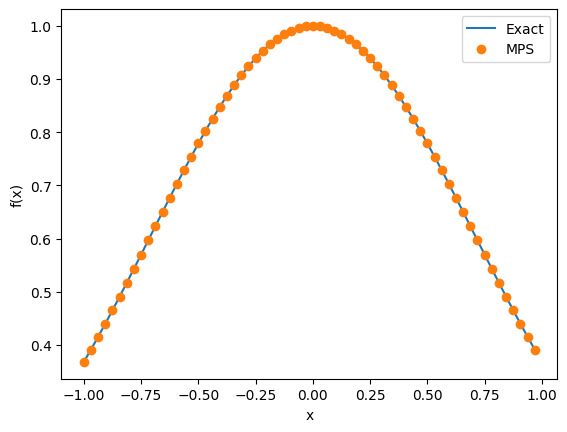

In [5]:
x = domain.to_vector()
y_vec = func(x)
y_mps = mps_gaussian.to_vector()
print("Error in Chebyshev norm: ", np.max(np.abs(y_vec - y_mps)))

plt.plot(x, y_vec, label="Exact")
plt.plot(x, y_mps, "o", label="MPS")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")

### Example 2: Loading multivariate functions

Because the method is agnostic to the initial MPS, it can be used to load some multivariate functions that are given by function composition. In this example, we show how to load a bivariate product Gaussian function,

$$
f(x, y) = e^{-(x^2 + y^2)}
$$

by composing a function $g(x) = e^{-x}$ with an initial polynomial $h(x, y) = x^2 + y^2$ expressed in MPS form.

In [6]:
from seemps.analysis.factories import mps_tensor_sum

We construct the initial MPS for $h(x,y)$ using the MPS tensor sum. Now, there are two possible qubit orders, *serial* or 'A' (by dimension) and *interleaved* or 'B' (by significance). The former is specially suitable for separable functions, such as the product Gaussian, while the latter is suitable for some multivariate functions with highly-correlated degrees of freedom.

In [9]:
num_qubits = 6
domain = RegularInterval(start, stop, 2**num_qubits)
mps_x = mps_interval(domain)

mps_x_squared = mps_x * mps_x  # x^2
mps_domain_A = mps_tensor_sum(
    [mps_x_squared, mps_x_squared], mps_order="A"
)  # x^2 + y^2 serial
mps_domain_B = mps_tensor_sum(
    [mps_x_squared, mps_x_squared], mps_order="B"
)  # x^2 + y^2 interleaved

The "tricky" part is matching the domain of definition of the Chebyshev coefficients with the support of the initial MPS. By default, they must match, so that the initial MPS can be affinely transformed to the canonical Chebyshev interval $[-1, 1]$. It is more intuitive to compute first the domain MPS and define the Chebyshev coefficient afterwards on its support.

In the example above, $h(x, y)$ has a support in $[0, x^2 + y^2) = [0, 2)$.

In [11]:
func = lambda x: np.exp(-x)
coeffs = ChebyshevExpansion.interpolate(func, start=0, stop=2).coeffs

Finally, load the function by composing $g(x)$ with the initial MPS for $h(x, y)$.

In [12]:
expansion = ChebyshevExpansion(coeffs, domain=(0,2))
mps_gaussian_2d_A = mps_polynomial_expansion(expansion, mps_domain_A)
mps_gaussian_2d_B = mps_polynomial_expansion(expansion, mps_domain_B)

In [13]:
def reorder_tensor(tensor, sites_per_dimension):
    """
    Reorders a given tensor between the MPS orderings 'A' and 'B' by transposing its axes.
    """
    dimensions = len(sites_per_dimension)
    shape_orig = tensor.shape
    tensor = tensor.reshape([2] * sum(sites_per_dimension))
    axes = [
        np.arange(idx, dimensions * n, dimensions)
        for idx, n in enumerate(sites_per_dimension)
    ]
    axes = [item for items in axes for item in items]
    tensor = np.transpose(tensor, axes=axes)
    return tensor.reshape(shape_orig)

In [14]:
x = domain.to_vector()
X, Y = np.meshgrid(x, x)
y_vec = np.exp(-(X**2 + Y**2))

shape = (x.size, x.size)
y_mps_A = mps_gaussian_2d_A.to_vector().reshape(shape)
y_mps_B = mps_gaussian_2d_B.to_vector().reshape(shape)

# Note: the interleaved tensor must be reshaped to be compared with the serial tensor.
# This is not a good practice so the required function is not present in the library.
y_mps_B = reorder_tensor(y_mps_B, [num_qubits, num_qubits])

print("Error in Chebyshev norm in serial order: ", np.max(np.abs(y_vec - y_mps_A)))
print("Error in Chebyshev norm in interleaved order: ", np.max(np.abs(y_vec - y_mps_B)))

Error in Chebyshev norm in serial order:  1.0681062700967914e-08
Error in Chebyshev norm in interleaved order:  5.039812334128868e-08


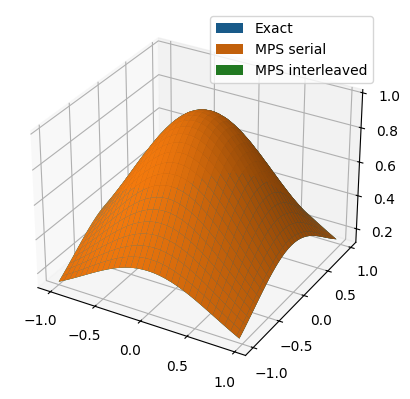

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, y_vec, label="Exact")
ax.plot_surface(X, Y, y_mps_A, label="MPS serial")
ax.plot_surface(X, Y, y_mps_B, label="MPS interleaved")
ax.legend()